<td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/learning_framework/blob/main/03_Advance/AutoEncoder/Vanilla/PyTorch.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

In [1]:
# Importing Modules
import random
from tqdm import tqdm

import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader 

from torchvision import datasets
from torchvision import transforms

from matplotlib import pyplot as plt

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set randomness
seed = 777
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set hyperparameter
epochs= 10
batch_size= 256

In [2]:
# MNIST dataset
mnist_train = datasets.MNIST(root='../../../data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
print("Downloading Train Data Done ! ")

mnist_test = datasets.MNIST(root='../../../data/',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)
print("Downloading Test Data Done ! ")

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# Defining Model
class BuildAE(nn.Module):
    def __init__(self, input_features=784):
        super(BuildAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_features, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, input_features),
            nn.Sigmoid()
        )

        self.init_weights(self.encoder)
        self.init_weights(self.decoder)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = BuildAE(input_features=784).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [4]:
for epoch in range(epochs):
    model.train()
    avg_loss = 0
    
    with tqdm(total=len(train_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        for i, (batch_img, batch_lab) in enumerate(train_loader):
            
            X = batch_img.to(device).view(batch_img.shape[0], -1)
            
            optimizer.zero_grad()
            y_pred = model.forward(X)
            loss = criterion(y_pred, X)
            
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            t.set_postfix({"loss": f"{loss.item():05.3f}"})
            t.update()

    model.eval()
    with tqdm(total=len(val_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        with torch.no_grad():
            val_loss = 0
            for i, (batch_img, batch_lab) in enumerate(val_loader):
                
                X = batch_img.to(device).view(batch_img.shape[0], -1)
                
                y_pred = model(X)
                val_loss += criterion(y_pred, X)
                t.set_postfix({"val_loss": f"{val_loss.item()/(i+1):05.3f}"})
                t.update()

            val_loss /= len(val_loader)
            
    print(f"Epoch : {epoch+1}, Loss : {(avg_loss/len(train_loader)):.3f}, Val Loss : {val_loss.item():.3f}")

print("Training Done !")

[1/10]: 100%|██████████| 40/40 [00:00<00:00, 64.58it/s, val_loss=0.077]


Epoch : 1, Loss : 0.157, Val Loss : 0.077


[2/10]: 100%|██████████| 40/40 [00:00<00:00, 77.54it/s, val_loss=0.071]


Epoch : 2, Loss : 0.072, Val Loss : 0.071


[3/10]: 100%|██████████| 40/40 [00:00<00:00, 76.39it/s, val_loss=0.068]


Epoch : 3, Loss : 0.069, Val Loss : 0.068


[4/10]: 100%|██████████| 40/40 [00:00<00:00, 76.48it/s, val_loss=0.062]


Epoch : 4, Loss : 0.065, Val Loss : 0.062


[5/10]: 100%|██████████| 40/40 [00:00<00:00, 61.97it/s, val_loss=0.057]


Epoch : 5, Loss : 0.060, Val Loss : 0.057


[6/10]: 100%|██████████| 40/40 [00:00<00:00, 63.19it/s, val_loss=0.053]


Epoch : 6, Loss : 0.055, Val Loss : 0.053


[7/10]: 100%|██████████| 40/40 [00:00<00:00, 67.25it/s, val_loss=0.049]


Epoch : 7, Loss : 0.051, Val Loss : 0.049


[8/10]: 100%|██████████| 40/40 [00:00<00:00, 69.15it/s, val_loss=0.046]


Epoch : 8, Loss : 0.048, Val Loss : 0.046


[9/10]: 100%|██████████| 40/40 [00:00<00:00, 75.51it/s, val_loss=0.043]


Epoch : 9, Loss : 0.045, Val Loss : 0.043


[10/10]: 100%|██████████| 40/40 [00:00<00:00, 65.93it/s, val_loss=0.040]

Epoch : 10, Loss : 0.042, Val Loss : 0.040
Training Done !


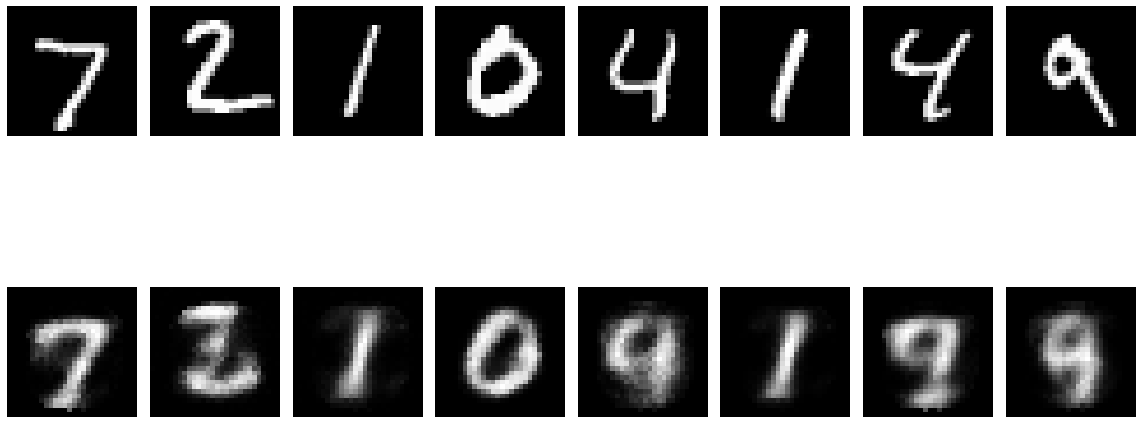

In [5]:
# Sample
for images, labels in val_loader:
    break

num_sample = 8
num_sample = num_sample if num_sample < batch_size else batch_size
col = num_sample
row = 3

sample_image = images[:num_sample].view(num_sample, -1).to(device)
prediction = model(sample_image).cpu().detach()

plt.figure(figsize=(col*2, row*2))

for i in range(num_sample):
    # 1st row: Input image 
    plt.subplot(row, col, i+1)
    plt.imshow(sample_image[i].reshape(28, 28).cpu(), cmap="gray")
    plt.axis("off")
    
    # 2nd row: Predicted image
    plt.subplot(row, col, (i+1)+num_sample*2)
    plt.imshow(prediction[i].reshape(28, 28).cpu(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()